In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math

# General Code

### Plotting

In [2]:
def plot_decision_boundary(X,W,t):
    #plot classes
    plt.scatter(X[0,:], X[1,:], c=t[0,:])
    
    #plot line
    x = [-5,5]
    y = [line(x[0],W), line(x[1],W)]
    plt.plot(x, y)
    plt.ylim(-3, 3)
    plt.xlim(-3,3)
    plt.show()
    
def line(x,W):
    k = -(W.T[0]/W.T[1])
    m = -W.T[2]/W.T[1]
    return k*x+m

### Generating

In [35]:
def gen_binary(n = 100, bias = True):
    mA = [1.2, 0.7]
    mB = [-1.5, 0.0]
    sigmaA = 0.4
    sigmaB = 0.35
    
    classA1 = np.random.normal(mA[0],sigmaA,n) 
    classA2 = np.random.normal(mA[1],sigmaA,n)
    classA = np.vstack((classA1,classA2))
    labelA = np.ones((1,n))
    
    classB1 = np.random.normal(mB[0],sigmaB,n)
    classB2 = np.random.normal(mB[1],sigmaB,n)
    classB = np.vstack((classB1,classB2))
    labelB = -np.ones((1,n))
    
    data = np.hstack((classA,classB))
    labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,2*n])
    t = np.zeros([1,2*n])
    index = np.random.permutation(2*n)
    
    for i in index:
        X[:2,i] = data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = labels[0,index[i]]
    
    return X, t


def gen_nonlin_sep(n = 100, bias = True, subsample_method = 0):
    
    mA = [1.0, 0.3]
    mB = [0.0, -0.1]
    sigmaA = 0.2
    sigmaB = 0.3
    
    classA1 = np.hstack((np.random.normal(-mA[0],sigmaA,math.floor(n/2)), \
                        np.random.normal(mA[0],sigmaA,math.floor(n/2))))
    classA2 = np.random.normal(mA[1],sigmaA,n)
    classA = np.vstack((classA1,classA2))
    labelA = np.ones((1,n))
      
    classB1 = np.random.normal(mB[0],sigmaB,n)
    classB2 = np.random.normal(mB[1],sigmaB,n)
    classB = np.vstack((classB1,classB2))
    labelB = -np.ones((1,n))
    
    data = np.hstack((classA,classB))
    labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,2*n])
    t = np.zeros([1,2*n])
    index = np.random.permutation(2*n)
    
    for i in index:
        X[:2,i] = data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = labels[0,index[i]]
    
    return X, t




def gen_W(X):
    W = np.random.normal(0, 1, (1, X.shape[0]))
    
    #bias
    if X[2,0] == 0:
        W.T[2] = 0
        
    return W

# Subsampling

In [147]:
def subsample_data(data, labels, method = 1, bias = 1):
    '''
    Returns a properly subsampled dataset according to
    the method specified by the user.
    
    Subsample methods:
    1 = random 25% from each class
    2 = random 50% from class A
    3 = random 50% from class B
    4 = 20% from left A and 80% from right A
    '''
    data_dim = data.shape[0]
    n = int(data.shape[1]/2)
    
    classA = np.zeros([data_dim, n])
    classB = np.zeros([data_dim, n])
    countA = 0
    countB = 0
    
    for i in range(0,2*n):
        if labels[:,i] == 1:
            classA[:,countA] = data[:,i]
            countA += 1
        else:
            classB[:,countB] = data[:,i]
            countB += 1
            
    if method == 1:
        classA = classA[:,0:math.floor(0.75*n)]
        labelA = np.ones((1,math.floor(0.75*n)))
        
        classB = classB[:,0:math.floor(0.75*n)]
        labelB = -np.ones((1,math.floor(0.75*n)))        
        
    elif method == 2:
        classA = classA[:,0:math.floor(n/2)]
        labelA = np.ones((1,math.floor(n/2)))
        labelB = -np.ones((1,n))
    
    elif method == 3:
        classB = classB[:,0:math.floor(n/2)]
        labelB = -np.ones((1,math.floor(n/2)))
        labelA = np.ones((1,n))
    
    elif method == 4:
        classA1 = np.zeros([data_dim, math.floor(n/2)])
        classA2 = np.zeros([data_dim, math.floor(n/2)])
        countA1 = 0
        countA2 = 0
        
        for i in range(0,n):
            if classA[0,i] < 0:
                classA1[:,countA1] = classA[:,i]
                countA1 += 1
            else:
                classA2[:,countA2] = classA[:,i]
                countA2 += 1
        
        classA1 = classA1[:,0:math.floor(0.8*math.floor(n/2))]
        classA2 = classA2[:,0:math.floor(0.2*math.floor(n/2))]
        classA = np.hstack((classA1,classA2))
        labelA = np.ones((1,math.floor(n/2)))
        labelB = -np.ones((1,n))
    
    new_data = np.hstack((classA,classB))
    new_labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,math.floor(1.5*n)])
    t = np.zeros([1,math.floor(1.5*n)])
    index = np.random.permutation(math.floor(1.5*n))
    
    for i in index:
        X[:2,i] = new_data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = new_labels[0,index[i]]

    return X, t        
    
            

# Perceptron

In [141]:
def prediction(data, weight):
    activation = weight[len(data)-1]
    for i in range(len(data)-1):
        activation += weight[i]*data[i]
    if activation >=0:
        return 1.0
    else :
        return -1.0
    
def weight_update_perceptron(dataset, labels, lr, n_epoch):
    weights = np.zeros(len(dataset[0]))
    print('l = ',len(dataset[0]))
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(dataset)-1):
            data = dataset[:,i]
            p = prediction(data, weights)
            error = (labels[:,i] - p)/2
            sum_error += abs(error)
            #weights[len(data)-1] = weights[len(data)-1] + (lr* error)
            for j in range(len(data)-1):
                weights[j] = weights[j] + (lr*error*data[j])
        #print('epoch=%d, lr=%.3f, error=%.3f' % (epoch, lr, sum_error))
    return weights

#dataset, labels = gen_binary(5)
#dataset = np.transpose(dataset)
#w = weight_update_perceptron(dataset, labels, 0.1, 10)
#print("w = ", w)

# Delta Rule

In [142]:
def delta(W, x, t, eta):
    inner = np.dot(W,x) - t
    return eta * np.dot(inner, np.transpose(x))

def run_delta(W, X, T, eta, n_epochs):
    Wnew = W[:]
    for e in range(n_epochs):
        for i in range(X.shape[1]):
            x = X[:,i,None]
            t = T[:,i]
            Wnew = Wnew - delta(Wnew,x,t,eta)
    return Wnew

def run_delta_batch(W, X, T, eta, n_epochs):
    Wnew = W[:]
    for e in range(n_epochs):
        Wnew = Wnew - eta*np.dot((np.dot(Wnew,X)-T),X.T)
    return Wnew


# Run Classifier

In [143]:
def run_evaluation(W, X, T):
    Y = np.dot(W, X)
    Y[Y > 0] = 1
    Y[Y < 0] = -1
    P = (Y==T)
    print("Classification accuracy =",np.sum(P)/P.shape[1]*100,"\b%.")

# Experiments on Linearly Separable Data

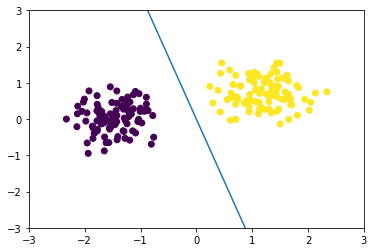

Classification accuracy = 100.0 %.


In [144]:
X, T = gen_binary(100, False)
W = gen_W(X)

#W1 = run_delta(W,X,T,0.001,100)
#plot_decision_boundary(X,W1,T)

W2 = run_delta_batch(W,X,T,0.001,1000)
plot_decision_boundary(X,W2,T)
run_evaluation(W2, X, T)

#W3 = weight_update_perceptron(X, T, 0.001, 10000)
#plot_decision_boundary(X,W3,T)


# Experiments on Non-Linearly Separable Data

In [145]:
X, T = gen_nonlin_sep()

Classification accuracy = 88.66666666666667 %.


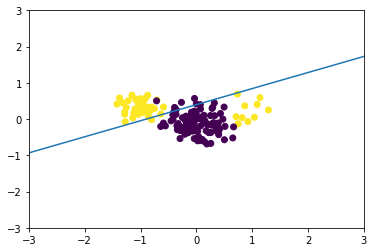

Classification accuracy = 71.5 %.


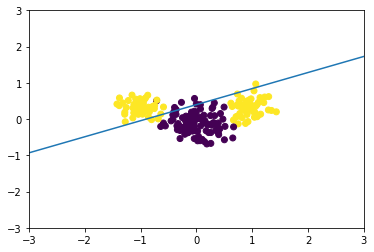

In [153]:
Xsub1, Tsub1 = subsample_data(X,T,4)
W = gen_W(Xsub1)

W0 = run_delta_batch(W,Xsub1,Tsub1,0.001,100)
run_evaluation(W0, Xsub1, Tsub1)
plot_decision_boundary(Xsub1,W0,Tsub1)
run_evaluation(W0, X, T)
plot_decision_boundary(X,W0,T)
